# Title

## Introduction

##### (1) Data Description:

players.csv contains 196 observations of 9 variables. The variables in each observation are as follows:
- experience <chr> (Amateur, Beginner, Regular, Veteran, or Pro)
The player's level of experience with minecraft
- subscribe <lgl> (boolean)
Whether the uder is a subscriber or not
- hashedEmail <chr>
The player's encoded email
- played_hours <dbl>
How many hours the player has logged in-game
- name <chr>
The player's name
- gander <chr> (Male, Female, Nonbinary, Two-Spirited, Agender, Prefer not to say, or Other)
The player's gender
- age <dbl>
The player's identity
- individualid <lgl> (All NA)
An unused value to give players anonymous IDs
- organizationName <lgl> (All NA)
An unused value to denote which organization the player is affiliated with

This data seems to have been obtained in a number of different ways: Demographic and account data was likely collected upon
each player making their account. The played_hours column was likely logged over time as the server recorded each player's
play sessions. This data is untidy because some columns do not contain any data. The individualid and organizationName columns contain no data, and the hashedEmail column has no meaning unless used in conjunction with the sessions dataframe.

sessions.csv contains 1535 observations of 5 variables. The variables in each observation are as follows:
- hashedEmail <chr>
The player's encoded email
- start_time <chr>
The date and time at the beginning of the play session
- end_time <chr>
The date and time at the end of the play session
- original_start_time <dbl>
The time in nanoseconds between the unix epoch (January 1, 1970, 00:00:00 UTC) and the play session start,
in scientific notation
- original_end_time <dbl>
The time in nanoseconds between the unix epoch (January 1, 1970, 00:00:00 UTC) and the play session end,
in scientific notation

This data seems to have been obtained from the game server every time a player logged on to play. The server has recorded
the timing of the session, in several different formats. The data is not tidy, because the start_time and end_time columns
contain multiple different observations, with the date and the time formatted differently. Again, the hashedEmail is not meaningful in itself, but can be used to match players to their play sessions.

Our group will try to answer the question: "How does age predict the number of hours played?"
Our variable of interest is played_hours, and our explanatory variables will be age. 
We think that certain ages will indicate higher average game hours. We hypothesize that people of similar ages will have similar interests, motivation, and similar amounts of free time. Therefore, people of similar age will play a similar amount of Minecraft.
We will isolate our predictor variable and interest variable columns in the players.csv dataset and look for correlations between predictors and interest variable. 

## Methods & Results

In [21]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

First, we will use the read function to get the dataframes from the link.

In [22]:
# Read players.csv
players <- read_csv("https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz")

# Read sessions.csv
sessions <- read_csv("https://drive.google.com/uc?export=download&id=14O91N5OlVkvdGxXNJUj5jIsV5RexhzbB")

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


To answer our quesiton, we are going to select the variables experience, played hours, and age to create the dataframe we will use for our prediction.

In [75]:
players_select <- players |>
    select(played_hours, age)

players_select

played_hours,age
<dbl>,<dbl>
30.3,9
3.8,17
0.0,17
⋮,⋮
0.0,17
2.3,17
0.2,91


Now we're going to plot Age with respect to played_hours to get a general idea of our plot and to see which prediction method to use. 

Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”


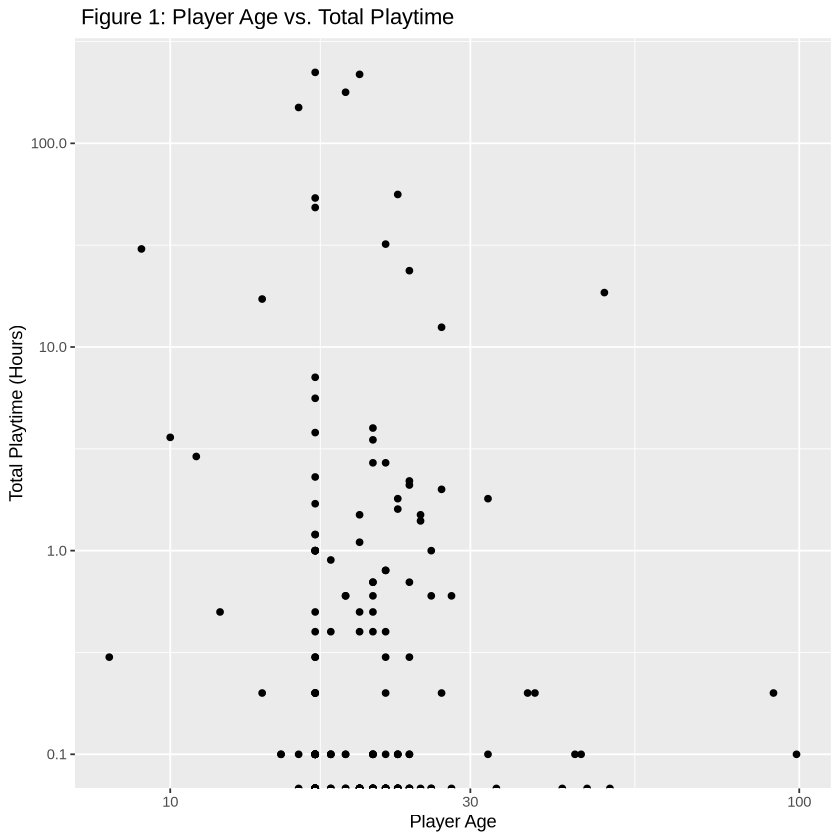

In [77]:
# Age Plot

demographics_playtime_plot <- players_tidy |>
ggplot(aes(x=age, y=played_hours, )) +
scale_x_log10() +
scale_y_log10() +
labs(x= "Player Age",
     y="Total Playtime (Hours)",
    title=" Figure 1: Player Age vs. Total Playtime") +
geom_point()
demographics_playtime_plot


The "Player Age vs. Total Playtime" plot shows us that the majority of players are around age 20, and that most players play for 10 hours or less. There is no clear linear correlation between player age and playtime. A few age outliers were likely not being truthful in the survey, so we will have to deal with outliers.
We conclude that KNN regression be the best predictive model to use in predicting hours played from the predictive variable "age".

We think KNN regression will work best to analyze our question, based on what the first graph shows. Since there is no visible linearity between age and playtime, it's best to use KNN regression to predict playtime's relation to age. However, KNN predictions get less meaningful as we approach the higher end of the data set, when there are fewer nearby datapoints. We will be making the assumptions that there are certain outliers that may be excluded, since it seems to me that some people may not be honest on the intake surveys. We will compare and select the best number of neighbors using a vfold selection process. We will split the data into 2 sets, one for testing and one for training. I will recommend a 75-25 training-testing split, because we want plenty of training data to do vfold selection and 75 is the higherst proportion we have used in class thus far. The training set will be further split into 5 to facilitate the selection of the right number of neighbors, and the right model will be selected based on RMSE.

After converting the experience into numberical values we can start building up our knn-regression model. First step is going to be creating our training and testing data.


In [79]:
#initial split
players_split <- initial_split(players_new, prop = .75, strata = played_hours)

# Training data
players_training <- training(players_split)
#Testing Data
players_testing <- testing(players_split)

players_training
players_testing

played_hours,age,experience,experience_num
<dbl>,<dbl>,<chr>,<dbl>
0.0,17,Veteran,5
0.1,21,Regular,4
0.0,17,Amateur,1
⋮,⋮,⋮,⋮
32.0,22,Amateur,1
1.7,17,Pro,3
2.3,17,Amateur,1


played_hours,age,experience,experience_num
<dbl>,<dbl>,<chr>,<dbl>
30.3,9,Pro,3
1.6,23,Veteran,5
0.2,22,Amateur,1
⋮,⋮,⋮,⋮
0,17,Amateur,1
0,17,Amateur,1
0,17,Amateur,1


In [47]:
set.seed(1234)

players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("regression")


players_recipe <- recipe(played_hours ~ age, data = players_new)

players_vfold <- vfold_cv(players_training, v = 5, strata = played_hours)

players_workflow <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_spec)

gridvals <- tibble(neighbors = seq(1,50, by = 10))

players_results <- players_workflow |>
    tune_grid(resamples = players_vfold, grid = gridvals) |>
    collect_metrics()
players_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,23.909028308,5,9.4494602265,Preprocessor1_Model1
1,rsq,standard,0.001311431,5,0.0006124372,Preprocessor1_Model1
11,rmse,standard,22.600036296,5,8.1690104343,Preprocessor1_Model2
⋮,⋮,⋮,⋮,⋮,⋮,⋮
31,rsq,standard,0.02140552,5,0.001289303,Preprocessor1_Model4
41,rmse,standard,21.98633653,5,8.372320288,Preprocessor1_Model5
41,rsq,standard,0.00859512,5,0.003904688,Preprocessor1_Model5


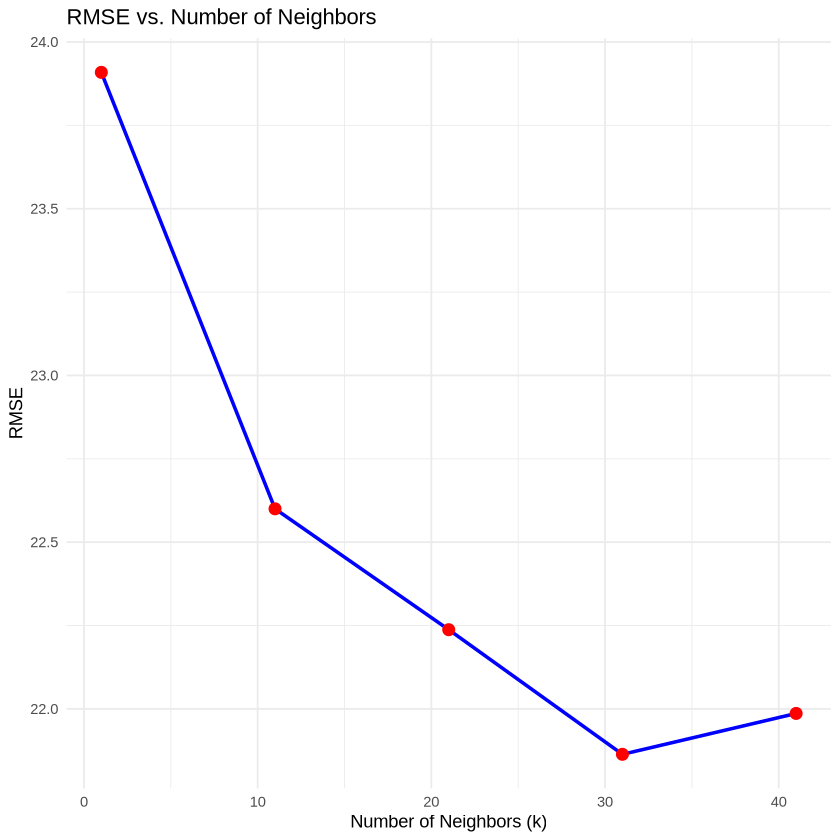

In [48]:
rmse_data <- players_results |>
  filter(.metric == "rmse")

rmse_plot <- rmse_data |>
  ggplot(aes(x = neighbors, y = mean)) +  
  geom_line(color = "blue", size = 1) +         
  geom_point(color = "red", size = 3) +         
  labs(
    x = "Number of Neighbors (k)",   
    y = "RMSE",                      
    title = "RMSE vs. Number of Neighbors"
  ) +
  theme_minimal()

rmse_plot


In [49]:
players_min <- players_results |>
    filter(.metric == "rmse") |>
    slice_min(mean, n=1)
players_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
31,rmse,standard,21.86374,5,8.392127,Preprocessor1_Model4


In [45]:
set.seed(1234) # DO NOT REMOVE

k_min <- players_min |>
          pull(neighbors)

players_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
          set_engine("kknn") |>
          set_mode("regression")

players_best_fit <- workflow() |>
          add_recipe(players_recipe) |>
          add_model(players_best_spec) |>
          fit(data = players_training)

players_summary <- players_best_fit |>
           predict(players_testing) |>
           bind_cols(players_testing) |>
           metrics(truth = played_hours, estimate = .pred)

players_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,3.186728e+01
rsq,standard,8.445424e-06
mae,standard,5.672000e+00


Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”


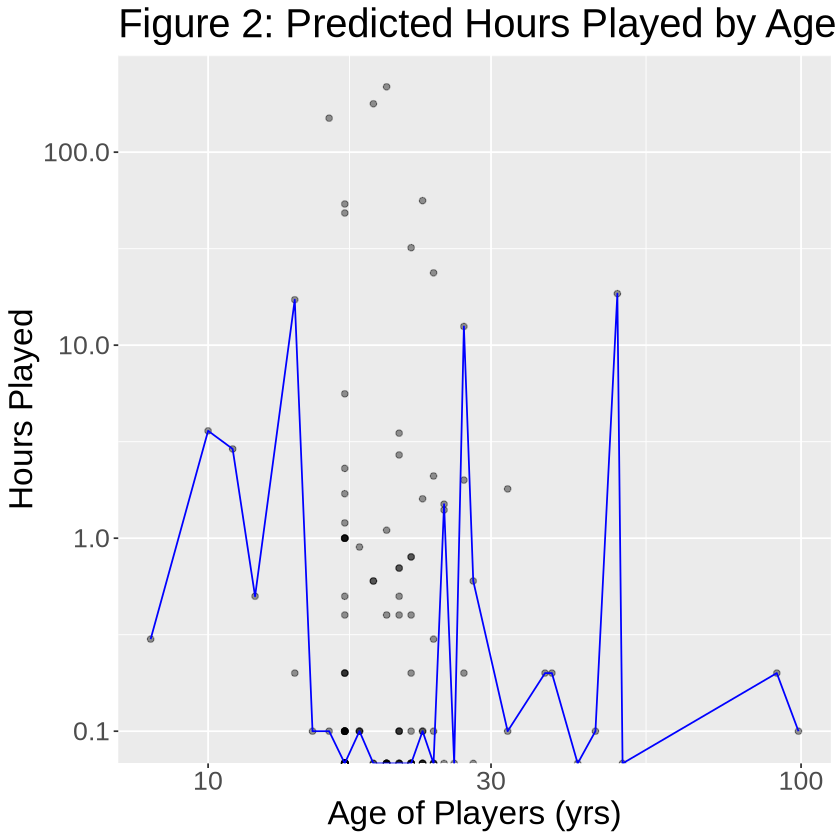

In [46]:
players_preds <- players_best_fit |>
                predict(players_training) |>
                bind_cols(players_training)

age_plot <- ggplot(players_preds, aes(x = age, y = played_hours)) +
scale_x_log10() +
scale_y_log10() +
            geom_point(alpha = 0.4) +
            xlab("Age of Players (yrs)") +
            ylab("Hours Played") + 
            geom_line(data = players_preds, aes(x = age, y = .pred), color = "blue") +
            ggtitle("Figure 2: Predicted Hours Played by Age") +
            theme(text = element_text(size = 20))

age_plot

## Discussion

In [ ]:
summarize what you found
discuss whether this is what you expected to find?
discuss what impact could such findings have?
discuss what future questions could this lead to?

## References